# Predicting the car price based on its production year and mileage

# 1. Problem formulation:

The problem we focused on is predicting the car price based on its charakteristics. The dataset contains a large number of cars both new and used that were listed for sale in the otomoto.pl portal. We focused on one specific vehicle type - Audi A3 with the engine size of 2000cm^3. 

We chose this problem, because we are interested in purchasing a car in near futer and the analysis of the data can help us rate if the car price of specific parameters is reasonable or not. Another use case is to apply this model to vehicles with different brands and characteristic and check how common the model is/ 

The chosen dataset is called "Poland cars for sale dataset (200k adverts)" and can be found under this link https://www.kaggle.com/datasets/bartoszpieniak/poland-cars-for-sale-dataset. This dataset was created by webscraping over 200,000 car offers from one of the largest car advertisement sites in Poland (otomoto). It contains 25 parameters listed below:

ID - unique ID of offer <br>
Price - value of the price <br>
Currency - currency of the price (mostly polish złoty, but also some euro)<br>
Condition - new or used<br>
Vehicle_brand - brand of vehicle in offer<br>
Vehicle_model - model of vehicle in offer<br>
Vehicle_generation - generation of vehicle in offer<br>
Vehicle_version - version of vehicle in offer<br>
Production_year - year of car production<br>
Mileage_km - total distance that the car has driven in kilometers<br>
Power_HP - car engine power in horsepower<br>
Displacement_cm3 - car engine size in cubic centimeters<br>
Fuel_type - car fuel type<br>
CO2_emissions - car CO2 emissions in g/km<br>
Drive - type of car drive<br>
Transmission - type of car transmission<br>
Type - car body style<br>
Doors_number - number of car doors<br>
Colour - car body color<br>
Origin_country - country of origin of the car<br>
First_owner - whether the owner is the first owner<br>
First_registration_date - date of first registration<br>
Offer_publication_date - date of publication of the offer<br>
Offer_location - address provided by the issuer<br>
Features - listed car features (ABS, airbag, parking sensors e.t.c)<br>

**DAG Diagram**

Based on the data, we created a DAG diagram to describe what parameters affect the price and each other. We divided the data in categories - brand specification, useage specification, car characteristic and external appearance. We also draw the relation between CO2 emmision and parameters such as displacement, fuel type and horse type, which affect both the emmision and the price. 

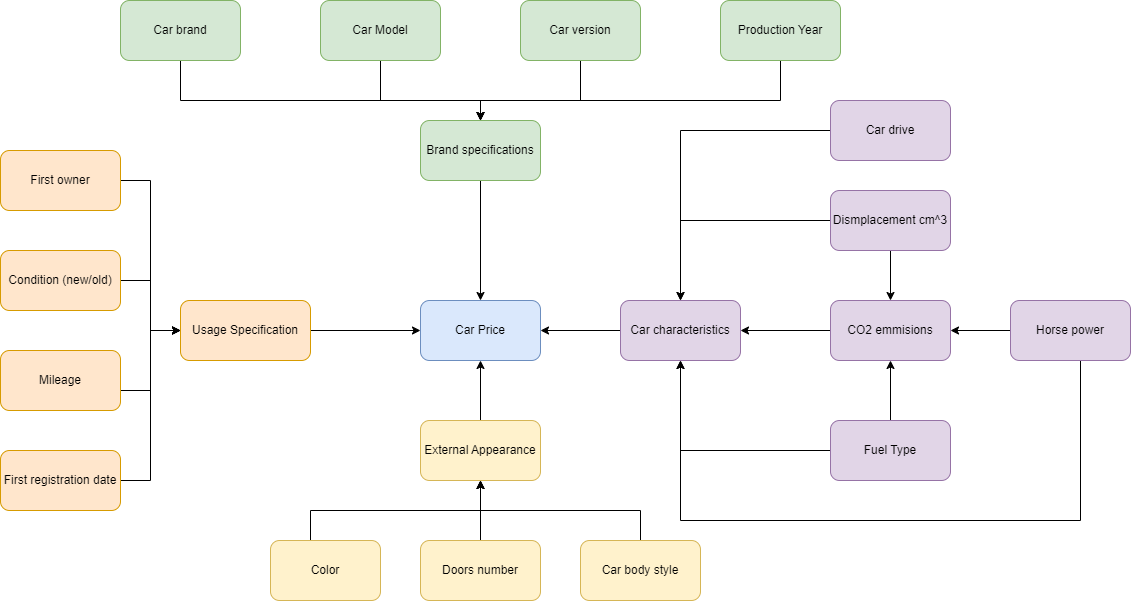

In [112]:
from IPython.display import Image
image_path = "/home/DA/project/DAG_cars.png"
Image(filename=image_path)


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import cmdstanpy
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from fitter import Fitter, get_common_distributions, get_distributions


BINS = 20

Functions

In [67]:
def price_plot(df, column_name, plot_trend = False):
    price = df["Price"]
    data = df[column_name]
    plt.figure()
    plt.plot(data,price, 'o')
    plt.xlabel(column_name)
    plt.ylabel("Price_PLN")
    if plot_trend:
        z = np.polyfit(data, price, 1)
        p = np.poly1d(z)
        print(f"Polyfit equation: {p}")
        plt.plot(data, p(data))
        plt.axvline(data.mean(), color="red")
        plt.axhline(price.mean(), color="red")
    plt.show()

Loading the data:

In [68]:
df = pd.read_csv("data/Car_sale_ads.csv")
list(df.columns)
df.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."
3,3,39900,PLN,Used,Abarth,500,NaN,NaN,2012,29000.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,30/04/2021,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air..."
4,4,97900,PLN,New,Abarth,595,NaN,NaN,2021,600.0,...,Manual,small_cars,3.0,blue,NaN,NaN,NaN,30/04/2021,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa..."


Unification of the price currency and selection of the desired columns

In [69]:
price = df["Price"].copy()
currency = df["Currency"].copy()

for idx, (p, c) in enumerate(zip(price, currency)):
    if c == "EUR":
        price_PLN = p * 4.6
        price[idx] = price_PLN
        currency[idx] = "PLN"


df["Currency"] = currency
df["Price"] = price

cols2add = ["Price", "Vehicle_brand", "Vehicle_model", "Production_year", "Mileage_km", "Power_HP", "Displacement_cm3"]
test_df = df[cols2add]
test_df.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
0,86200.0,Abarth,595,2021,1.0,145.0,1400.0
1,43500.0,Abarth,Other,1974,59000.0,75.0,1100.0
2,44900.0,Abarth,500,2018,52000.0,180.0,1368.0
3,39900.0,Abarth,500,2012,29000.0,160.0,1368.0
4,97900.0,Abarth,595,2021,600.0,165.0,1368.0


Due to the extensive size of the dataset and the wide range of car models included, we have made the decision to conduct our analysis solely on a single car model.<br>
***Chosen car model:***<br>
**Brand:** Audi <br>
**Model:** A3<br>

In [70]:
audi_cars = test_df[test_df['Vehicle_brand'] == "Audi"]
audi_a3_cars = audi_cars[audi_cars["Vehicle_model"] == 'A3']

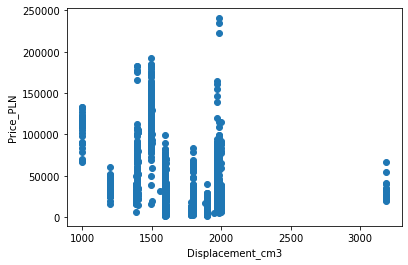

In [71]:
price_plot(audi_a3_cars,"Displacement_cm3")

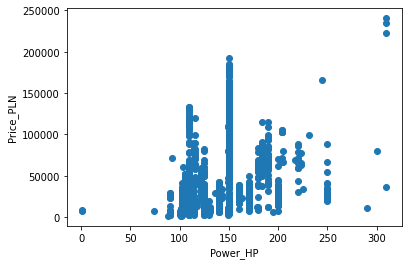

In [72]:
price_plot(audi_a3_cars,"Power_HP")

In [73]:
correlations = audi_a3_cars.iloc[:, 1:].corrwith(audi_a3_cars['Price'])
print(correlations)

Production_year     0.853472
Mileage_km         -0.764658
Power_HP            0.354174
Displacement_cm3   -0.301169
dtype: float64


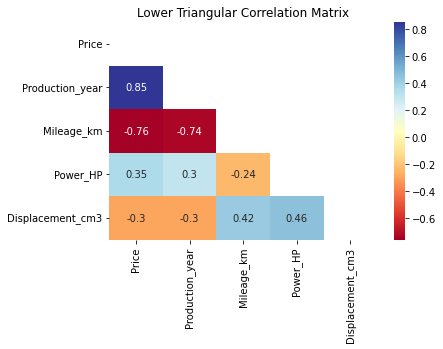

In [74]:
correlation_matrix = audi_a3_cars.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, mask=mask, annot=True, cmap='RdYlBu')
plt.title('Lower Triangular Correlation Matrix')
plt.show()

Due to small effect of engine power and displacement on the price of a vehicle, it was decided that only cars with a displacement of 2000ccm would be analysed to simplify analizis.

In [75]:
audi_a3_2010 = audi_a3_cars[audi_a3_cars["Production_year"] == 2010]
audi_a3_2000ccm = audi_a3_cars[audi_a3_cars["Displacement_cm3"] >= 1950]
audi_a3_2000ccm = audi_a3_2000ccm[audi_a3_2000ccm["Displacement_cm3"] <= 2050]
audi_a3_2000ccm = audi_a3_2000ccm.dropna()

In [76]:
if "audi_cars_data.csv" not in os.listdir("data"):
    audi_a3_2000ccm.to_csv('data/audi_cars_data.csv', index=False)

### Summary

In [77]:
audi_a3_2000ccm.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
1929,49900.0,Audi,A3,2015,208000.0,150.0,1968.0
1932,13900.0,Audi,A3,2008,227000.0,140.0,1968.0
1933,21900.0,Audi,A3,2008,313855.0,140.0,1968.0
1934,19900.0,Audi,A3,2007,242000.0,170.0,1968.0
1936,22900.0,Audi,A3,2006,240000.0,200.0,1984.0


Polyfit equation:  
4988 x - 9.99e+06


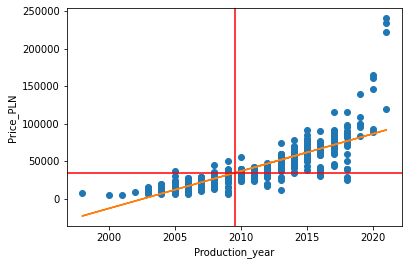

In [78]:
price_plot(audi_a3_2000ccm, "Production_year", True)

Polyfit equation:  
-0.2344 x + 8.109e+04


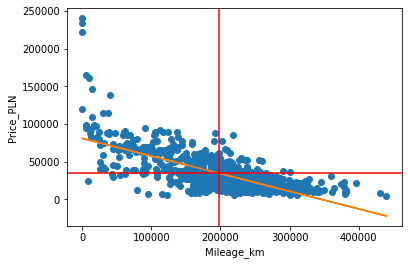

In [79]:
price_plot(audi_a3_2000ccm, "Mileage_km", True)

Polyfit equation:  
487.6 x - 4.072e+04


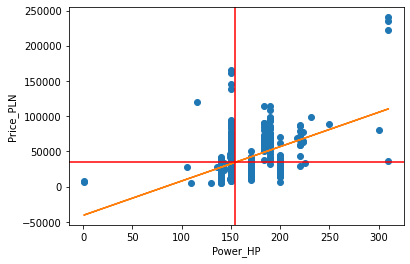

In [80]:
price_plot(audi_a3_2000ccm, "Power_HP", True)

Mean: 198361.37403598972


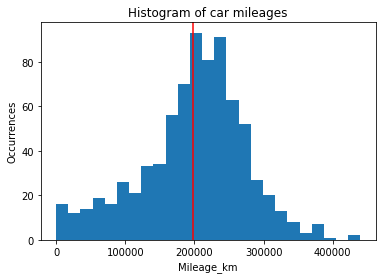

In [81]:
mileage_mean = np.mean(audi_a3_2000ccm["Mileage_km"])
print(f"Mean: {mileage_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Mileage_km"], bins = 25)
plt.axvline(mileage_mean, color="red")
plt.xlabel("Mileage_km")
plt.ylabel("Occurrences")
plt.title("Histogram of car mileages")
plt.show()

Mean: 2009.5719794344473


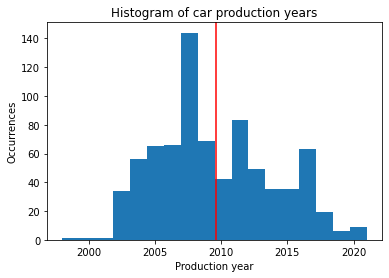

In [82]:
prod_mean = np.mean(audi_a3_2000ccm["Production_year"])
print(f"Mean: {prod_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Production_year"], bins = 18)
plt.axvline(prod_mean, color="red")
plt.xlabel("Production year")
plt.ylabel("Occurrences")
plt.title("Histogram of car production years")
plt.show()

Mean: 34600.235218509


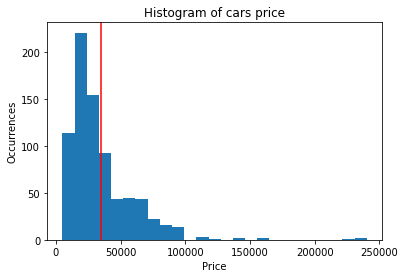

In [83]:
price_mean = np.mean(audi_a3_2000ccm["Price"])
print(f"Mean: {price_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Price"], bins = 25)
plt.axvline(price_mean, color="red")
plt.xlabel("Price")
plt.ylabel("Occurrences")
plt.title("Histogram of cars price")
plt.show()

## Data standarization ##

Due to the diversity of the data (production year (values form 2003 to 2021), mileage (values from 0 to 400000), price (values from 0 to 160000)), we decided to standardise the data using the MinMax scalar. This way we got all the data in the range from 0 to 1, without loosing information about data and making it easier to analyze it.

In [84]:
scaler = MinMaxScaler()
audi_a3_2000ccm_standarized_data = scaler.fit_transform(audi_a3_2000ccm.loc[:,["Price", "Production_year", "Mileage_km"]])
audi_a3_2000ccm_standarized = pd.DataFrame(audi_a3_2000ccm_standarized_data,columns=["Price", "Production_year", "Mileage_km"])
audi_a3_2000ccm_standarized.describe()

,Price,Production_year,Mileage_km
count,778.000000,778.000000,778.000000
mean,0.125764,0.503130,0.450820
std,0.110705,0.190895,0.173469
min,0.000000,0.000000,0.000000
25%,0.053109,0.347826,0.363635
50%,0.093048,0.478261,0.470453
75%,0.160497,0.652174,0.561363
max,1.000000,1.000000,1.000000


Polyfit equation:  
0.4875 x - 0.1195


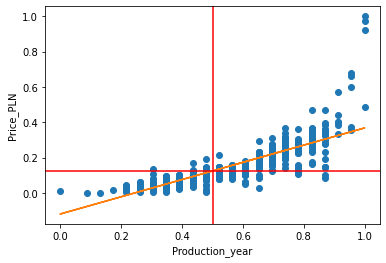

Polyfit equation:  
-0.4382 x + 0.3233


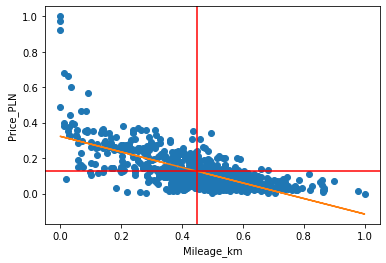

In [85]:
price_plot(audi_a3_2000ccm_standarized,"Production_year",True)
price_plot(audi_a3_2000ccm_standarized,"Mileage_km",True)

Mean: 0.45082005649101414


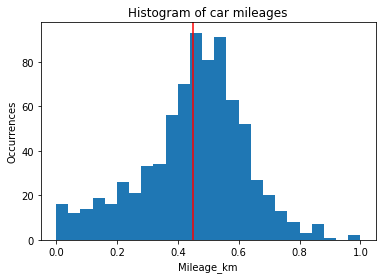

Mean: 0.5031295406281482


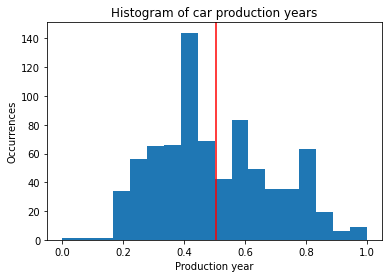

Mean: 0.12576418221431998
Var: 0.012239734156792626


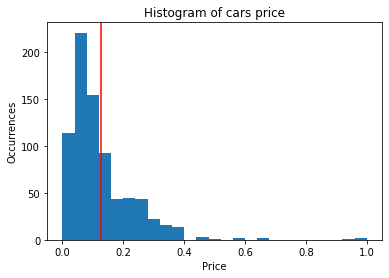

In [86]:
mileage_mean = np.mean(audi_a3_2000ccm_standarized["Mileage_km"])
print(f"Mean: {mileage_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Mileage_km"], bins = 25)
plt.axvline(mileage_mean, color="red")
plt.xlabel("Mileage_km")
plt.ylabel("Occurrences")
plt.title("Histogram of car mileages")
plt.show()

prod_mean = np.mean(audi_a3_2000ccm_standarized["Production_year"])
print(f"Mean: {prod_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Production_year"], bins = 18)
plt.axvline(prod_mean, color="red")
plt.xlabel("Production year")
plt.ylabel("Occurrences")
plt.title("Histogram of car production years")
plt.show()

price_mean = np.mean(audi_a3_2000ccm_standarized["Price"])
price_var = np.var(audi_a3_2000ccm_standarized["Price"])
print(f"Mean: {price_mean}")
print(f"Var: {price_var}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Price"], bins = 25)
plt.axvline(price_mean, color="red")
plt.xlabel("Price")
plt.ylabel("Occurrences")
plt.title("Histogram of cars price")
plt.show()

In [87]:
if 'audi_data_standarized.csv' not in os.listdir("data"):
    audi_a3_2000ccm_standarized.to_csv('data/audi_data_standarized.csv', index=False)

In [88]:
audi_a3_2000ccm_standarized = pd.read_csv("data/audi_data_standarized.csv")
audi_a3_2000ccm_standarized.head()

,Price,Production_year,Mileage_km
0,0.190769,0.739130,0.472726
1,0.037814,0.434783,0.515908
2,0.071804,0.434783,0.713306
3,0.063306,0.391304,0.549999
4,0.076053,0.347826,0.545454


# 3. Model

For this project we specified two prior models of exponential range distribution. We wanted to check how adding highly corelated parameter to the model will affect price estimation. 
In the first model we used linear regression model with exponnenital distribution. We estimate price only based on the production year. In the second model we add mileage as well.
<br><br>
Model 1 formula:
$$
  price = exponential((\alpha + \beta * production\_year)*\lambda )
$$
Model 2 formula:
$$
  price = exponential((\alpha -\beta_1 * mileage + \beta_2 * production\_year)*\lambda )
$$

## 3.1 Model 1- prior

***Priors selection***<br>
The choice of an exponential distribution for modeling used car prices is justified by the observation that newer and less used cars tend to have higher prices. The exponential distribution captures this pattern with its right-skewed shape, accommodating a higher concentration of lower-priced cars and a smaller number of higher-priced cars. The min-max scaling ensures that the production year variable is on a comparable scale for accurate analysis and modeling of the relationship between production year and used car prices.

The choice to use a normal distribution for $\alpha$, $\beta$ and $\lambda$ allows for capturing the natural variability of these parameters and is a common approach in statistical modeling for estimation and significance assessment.

In [89]:
model_exp1_ppc = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [90]:
N = len(audi_a3_2000ccm_standarized)

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N)
}
sim_exp_fit1=model_exp1_ppc.sample(data=data)
sim_exp_fit1_pd = sim_exp_fit1.draws_pd()
sim_exp_fit1_pd.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)

chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)




chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,price[1],price[2],price[3],price[4],price[5],price[6],price[7],price[8],...,price[773],price[774],price[775],price[776],price[777],price[778],alpha,beta,sigma,lambda
0,0.0,0.0,0.105195,0.167174,0.711009,0.006327,0.023779,0.014575,0.093657,0.034181,...,0.067077,0.000468,0.044011,0.021837,0.064800,0.078109,0.158116,0.352988,0.116625,39.7923
1,0.0,0.0,0.032936,0.001719,0.102338,0.353666,0.249956,0.017459,0.101930,0.106334,...,0.033959,0.137571,0.005238,0.040567,0.002834,0.070587,0.184970,0.385498,0.176368,40.0152
2,0.0,0.0,0.016656,0.043789,0.036351,0.616655,0.228353,0.077383,0.064425,0.008720,...,0.061551,0.011364,0.246932,0.007619,0.038981,0.027535,0.150371,0.357884,0.181312,39.9036
3,0.0,0.0,0.285560,0.081365,0.241231,0.167318,0.126170,0.216949,0.131051,0.096908,...,0.049293,0.033840,0.007374,0.022735,0.001567,0.061044,0.199287,0.343763,0.154765,40.1491
4,0.0,0.0,0.201843,0.072561,0.105279,0.081733,0.194447,0.047238,0.087672,0.080498,...,0.020130,0.095196,0.112169,0.049858,0.057298,0.001569,0.158854,0.332186,0.171331,39.9415


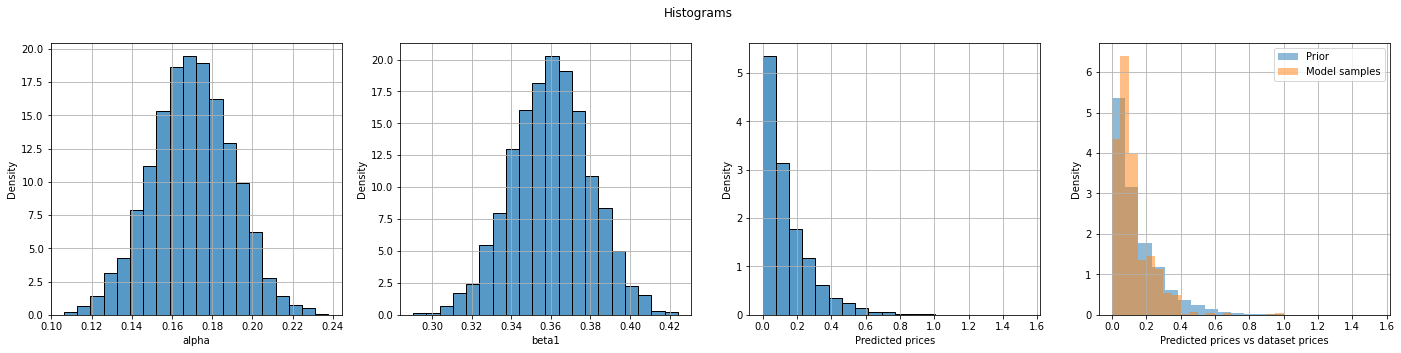

In [91]:
_, ax = plt.subplots(1, 4, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit1_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit1_pd, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit1_pd, x="price[1]", stat="density", ax=ax[2], bins=BINS)

ax[3].hist(sim_exp_fit1_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[3].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("Predicted prices"), 
ax[3].set_xlabel("Predicted prices vs dataset prices")

ax[3].set_ylabel("Density")
ax[3].legend()
plt.suptitle("Histograms")
plt.show()

The prior parameters were chosen through a semi-empirical process. Initially, a standard parameter from the literature was used, but further modifications were made to align the simulated data with the observed data. This adjustment ensured a closer match between the chosen priors and the actual data.

## 3.2 Model 1- posterior

In [92]:
model_exp_fit = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model1_fit.stan')
N = len(audi_a3_2000ccm_standarized)
#Parameters

data = {"N": N, 
        "mileage" : audi_a3_2000ccm_standarized['Mileage_km'],
        "production_year" : audi_a3_2000ccm_standarized['Production_year'],
        "price_observed": audi_a3_2000ccm_standarized['Price']
        }

sim_exp_pos1_fit=model_exp_fit.sample(data=data)
sim_exp_pos1_fit_pd = sim_exp_pos1_fit.draws_pd()
sim_exp_pos1_fit_pd.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


cha


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_lik[769],log_lik[770],log_lik[771],log_lik[772],log_lik[773],log_lik[774],log_lik[775],log_lik[776],log_lik[777],log_lik[778]
0,688.774,0.992027,0.522092,3.0,7.0,0.0,-688.483,0.163078,0.093421,0.098915,...,1.12857,1.50514,1.13224,1.68721,0.880598,1.26481,0.118243,1.40232,1.45739,0.875509
1,692.248,0.976427,0.522092,2.0,7.0,0.0,-687.583,0.151551,0.095218,0.132216,...,1.12853,1.47620,1.13200,1.64954,0.893021,1.26439,0.170924,1.38141,1.44823,0.888959
2,691.642,0.898055,0.522092,3.0,7.0,0.0,-689.180,0.144877,0.101951,0.180190,...,1.12830,1.46794,1.13175,1.64009,0.894674,1.26449,0.171860,1.37591,1.44893,0.890476
3,691.417,0.928710,0.522092,3.0,7.0,0.0,-690.580,0.153526,0.085891,0.125413,...,1.12802,1.47365,1.13144,1.64493,0.895328,1.26331,0.191424,1.37874,1.44262,0.891911
4,689.678,0.938565,0.522092,3.0,7.0,0.0,-688.286,0.168723,0.082123,0.169052,...,1.12845,1.51232,1.13214,1.69543,0.878974,1.26490,0.122992,1.40666,1.45560,0.874382


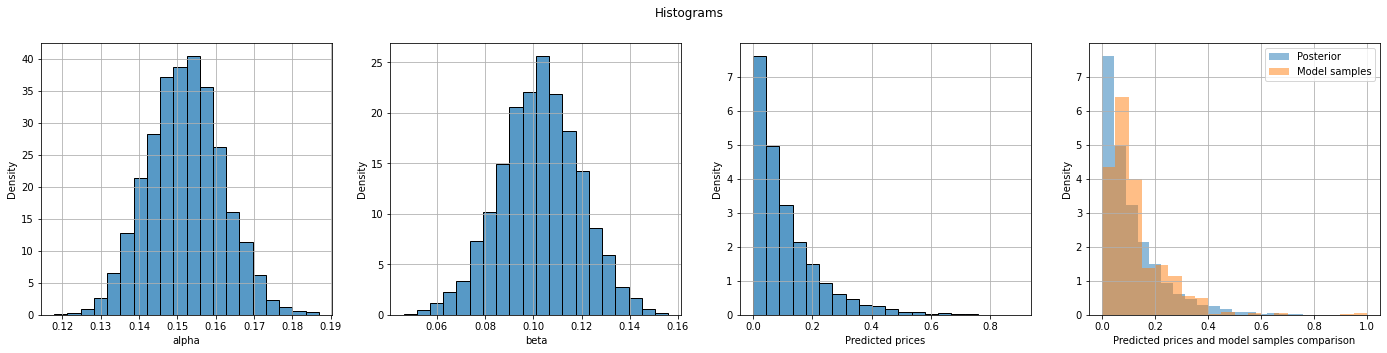

In [93]:
_, ax = plt.subplots(1, 4, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_pos1_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_pos1_fit_pd, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_pos1_fit_pd, x="price_estimated[1]", stat="density", ax=ax[2], bins=BINS)

ax[3].hist(sim_exp_pos1_fit_pd["price_estimated[1]"], bins=BINS, alpha=0.5, density=True, label="Posterior")
ax[3].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta"), 
ax[2].set_xlabel("Predicted prices"), 
ax[3].set_xlabel("Predicted prices and model samples comparison")

ax[3].set_ylabel("Density")
ax[3].legend()
plt.suptitle("Histograms")
plt.show()

The posterior data analysis, which includes comparing the histogram of the prior distribution with the posterior distribution and real data, indicates a good fit. This comparison demonstrates that the chosen priors align well with the observed data, suggesting that the model captures the underlying patterns and provides reliable estimates.

In [94]:
summary = sim_exp_pos1_fit.summary()
summary.head()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,690.00,0.03200,1.4000,690.000,690.00,690.00,2000.0,150.0,1.0
alpha,0.15,0.00019,0.0097,0.140,0.15,0.17,2500.0,190.0,1.0
beta,0.10,0.00031,0.0160,0.076,0.10,0.13,2800.0,210.0,1.0
sigma,0.15,0.00035,0.0200,0.120,0.15,0.18,3100.0,230.0,1.0
lambda,40.00,0.00310,0.2000,40.000,40.00,40.00,4100.0,310.0,1.0


## 3.3 Model 2- prior

The extension of the first model to include mileage introduces an additional predictor variable, expanding the model's scope. This extension allows for the consideration of mileage as a factor influencing used car prices. By incorporating mileage into the model, it is possible to assess its impact on the relationship between other predictors (such as production year) and used car prices.

In the extended model, the inclusion of mileage as a predictor involved adding a normal distribution parameter, "beta1". Other parameters stayed the same.

In [95]:
model_exp2_ppc = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model2_ppc.stan')

#Parameters
N = len(audi_a3_2000ccm_standarized)
mu_a =0.17
sig_a =0.02
mu_b1 = 0.36
sig_b1 = 0.02
mu_b2 = 0.36
sig_b2 = 0.02

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N),
        "mu_a" : mu_a,
        "sig_a" : sig_a,
        "mu_b1" : mu_b1,
        "mu_b2" : mu_b2,
        "sig_b1" : sig_b1,
        "sig_b2" : sig_b2,
        }


sim_exp_fit2=model_exp2_ppc.sample(data=data)
sim_exp_fit2_pd = sim_exp_fit2.draws_pd()
sim_exp_fit2_pd.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)

chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)



chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)

chain 1 |█████     | 00:00 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,price[1],price[2],price[3],price[4],price[5],price[6],price[7],price[8],...,price[774],price[775],price[776],price[777],price[778],alpha,beta1,beta2,sigma,lambda
0,0.0,0.0,0.008044,0.012994,0.097141,0.044838,0.022054,0.016585,0.014760,0.006179,...,0.683806,0.382428,0.038925,0.052202,0.003538,0.183584,0.400784,0.348201,0.154954,40.2377
1,0.0,0.0,0.112681,0.375303,0.463829,0.024006,0.174805,0.039711,0.090907,0.156079,...,0.084205,0.106477,0.148148,0.025368,0.196772,0.222065,0.322553,0.384911,0.121763,40.0239
2,0.0,0.0,0.028215,0.574179,0.023458,0.070346,0.241936,0.068272,0.166844,0.222689,...,0.002784,0.516028,0.421544,0.004406,0.569425,0.168706,0.379475,0.320288,0.154951,40.0240
3,0.0,0.0,0.060281,0.262550,0.414998,0.216382,0.068187,0.013749,0.056582,0.465976,...,0.071184,0.075740,0.183388,0.015010,0.108223,0.159335,0.373443,0.400956,0.149039,40.1117
4,0.0,0.0,0.274464,0.241720,0.183472,0.103522,0.071789,0.267548,0.005479,0.032669,...,0.023716,0.095393,0.132287,0.182695,0.224004,0.184697,0.343617,0.376075,0.197626,39.8372


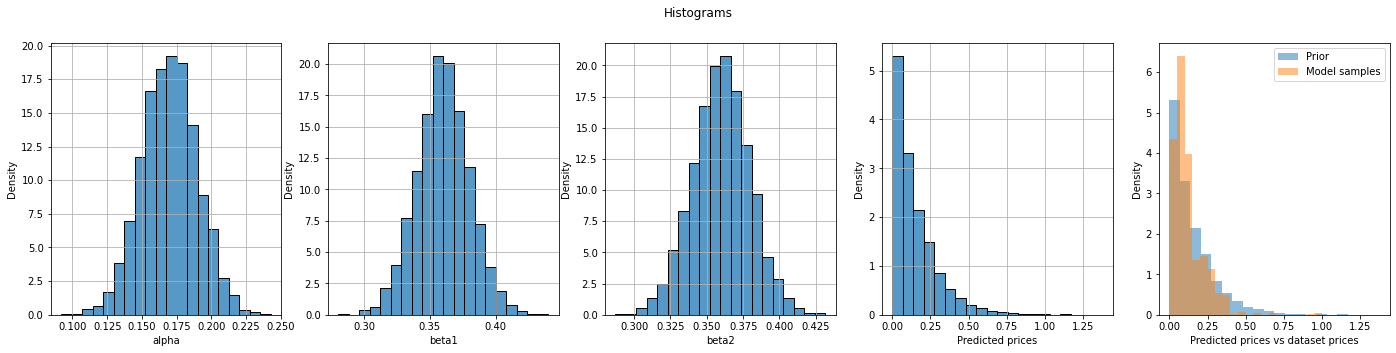

In [96]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit2_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="price[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_fit2_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

The comparison between the prior model and real data suggests a satisfactory fit, indicating that the chosen priors accurately capture the underlying patterns and characteristics of the observed data.

## 3.4 Model 2- posterior

In [97]:
model_exp2_fit = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model2_fit.stan')
N = len(audi_a3_2000ccm_standarized)
#Parameters

data = {"N": N, 
        "mileage" : audi_a3_2000ccm_standarized['Mileage_km'],
        "production_year" : audi_a3_2000ccm_standarized['Production_year'],
        "price_observed": audi_a3_2000ccm_standarized['Price']
        }

sim_exp_pos2_fit=model_exp2_fit.sample(data=data)
sim_exp_pos2_fit_pd = sim_exp_pos2_fit.draws_pd()
sim_exp_pos2_fit_pd.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status







chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)









































chain 1 |█▊        | 00:05 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:06 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:06 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:07 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:09 Sampling completed                       
chain 2 |██████████| 00:09 Sampling completed                       
chain 3 |██████████| 00:09 Sampling completed                       
chain 4 |██████████| 00:09 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta1,beta2,...,log_lik[769],log_lik[770],log_lik[771],log_lik[772],log_lik[773],log_lik[774],log_lik[775],log_lik[776],log_lik[777],log_lik[778]
0,561.648,0.865940,0.367327,3.0,7.0,0.0,-559.344,0.214010,0.131249,0.091832,...,1.12794,1.50374,1.13044,1.61345,0.876493,1.25337,0.139820,1.33088,1.47516,0.869554
1,561.771,0.953055,0.367327,4.0,15.0,0.0,-560.799,0.199673,0.123358,0.115722,...,1.12732,1.49834,1.13149,1.61327,0.874337,1.24823,0.104832,1.33254,1.47544,0.865808
2,561.992,0.902669,0.367327,4.0,15.0,0.0,-559.860,0.205094,0.129223,0.106872,...,1.12794,1.49636,1.13055,1.60552,0.877291,1.25098,0.126958,1.32567,1.47539,0.869556
3,557.870,0.896103,0.367327,3.0,7.0,0.0,-557.171,0.195366,0.133712,0.132126,...,1.12729,1.48952,1.13113,1.59630,0.875139,1.24306,0.093943,1.31781,1.47503,0.865580
4,558.072,0.918945,0.367327,2.0,3.0,0.0,-556.436,0.191588,0.136474,0.131592,...,1.12827,1.47783,1.12951,1.57630,0.880847,1.24593,0.117036,1.30198,1.47531,0.871936


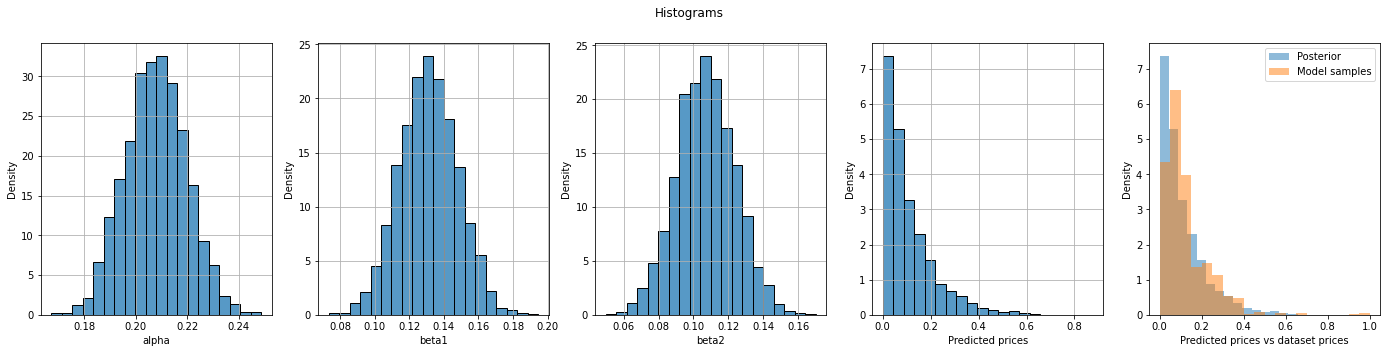

In [98]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_pos2_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="price_estimated[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_pos2_fit_pd["price_estimated[1]"], bins=BINS, alpha=0.5, density=True, label="Posterior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

The posterior distribution of the model, after fitting it to the real data, exhibits a good fit, indicating that the model effectively captures the patterns and characteristics present in the observed data.

In [99]:
summary = sim_exp_pos2_fit.summary()
summary.head(6)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,560.00,0.03800,1.600,560.000,560.00,560.00,1900.0,110.0,1.0
alpha,0.21,0.00024,0.012,0.190,0.21,0.23,2400.0,140.0,1.0
beta1,0.13,0.00033,0.017,0.100,0.13,0.16,2600.0,140.0,1.0
beta2,0.11,0.00030,0.017,0.079,0.11,0.13,3100.0,180.0,1.0
sigma,0.15,0.00035,0.020,0.120,0.15,0.18,3300.0,190.0,1.0
lambda,40.00,0.00310,0.200,40.000,40.00,40.00,4100.0,230.0,1.0


# 4. Model comparison

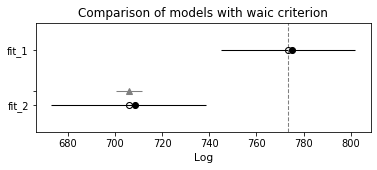

In [100]:
compare_model_waic = az.compare(
 {
 "fit_1": az.from_cmdstanpy(sim_exp_pos1_fit),
 "fit_2": az.from_cmdstanpy(sim_exp_pos2_fit)
 },
 ic="waic",
)

ax = az.plot_compare(compare_model_waic)
ax.set_title(f"Comparison of models with waic criterion")
plt.show()


In [101]:
display(compare_model_waic)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fit_1,0,773.377356,1.628045,0.00000,1.000000e+00,28.568516,0.000000,False,log
fit_2,1,705.891795,2.605451,67.48556,6.906475e-11,32.942253,5.456107,False,log


The results of the WAIC (Watanabe-Akaike information criterion) comparison are as follows:

- rank: The ranking of the models based on their WAIC values. In this case, fit_1 is ranked at 0, indicating that fit_1 is preffered model
- waic: The WAIC value for each model. The WAIC is a measure of the out-of-sample predictive accuracy of the model. In this case, fit_1 has a higher WAIC value of 773.187452, while fit_2 has a lower WAIC value of 705.928822.
- p_waic: The estimated effective number of parameters based on the WAIC, used to compare the complexity of the models.
- d_waic: The difference in WAIC values between the models. In this case, fit_2 has a higher WAIC value by 67.25863 compared to fit_1.
- weight: The weight of each model in the model comparison, representing the probability of each model being the best model among the compared models. In this case, fit_1 has a weight of 1.0, indicating it is the preferred model over fit_2, which has a weight of 0.0.
- se: The standard error of the WAIC estimate, providing a measure of uncertainty associated with the WAIC value.
- dse: The standard error of the difference in WAIC values, providing a measure of uncertainty associated with the difference in WAIC values between the models.
- warning: Indicates whether there are any warnings associated with the model comparison. In this case, there is no warning.
waic_scale: The scale of the WAIC values. In this case, the values are on a log scale.

Based on these results, fit_2 is ranked higher with a lower WAIC value, indicating better model performance. Although the weight for fit_1 is 1.0, suggesting it is the preferred model, this contradicts the lower WAIC value of fit_2. Additionaly the rank suggest to choose fit_1. Therefore, the results of fit_1 and fit_2 overlap and further analysis is needed

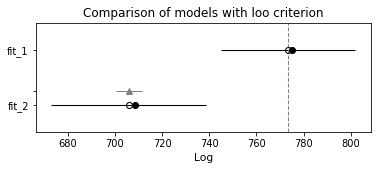

In [102]:
compare_model_loo = az.compare(
 {
 "fit_1": az.from_cmdstanpy(sim_exp_pos1_fit),
 "fit_2": az.from_cmdstanpy(sim_exp_pos2_fit)
 },
 ic="loo",
)

ax = az.plot_compare(compare_model_loo)
ax.set_title(f"Comparison of models with loo criterion")
plt.show()

In [103]:
display(compare_model_loo)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
fit_1,0,773.377433,1.627967,0.00000,1.000000e+00,28.568493,0.000000,False,log
fit_2,1,705.892293,2.604953,67.48514,5.073275e-12,32.942102,5.455964,False,log


The results of the LOO analysis comparison are as follows:

- rank: The ranking of the models based on their LOO values. In this case, fit_1 is ranked at 0, indicating that fit_1 is preffered.
- loo: The LOO value for each model. The LOO is a measure of the out-of-sample predictive accuracy of the model. In this case, fit_1 has a higher LOO value of 773.186874, while fit_2 has a lower LOO value of 705.931121.
- p_loo: The estimated effective number of parameters based on the LOO, used to compare the complexity of the models.
- d_loo: The difference in LOO values between the models. In this case, fit_2 has a higher LOO value by 67.255753 compared to fit_1.
- weight: The weight of each model in the model comparison, representing the probability of each model being the best model among the compared models. In this case, fit_1 has a weight of 1.0, indicating it is the preferred model over fit_2, which has a weight of 0.0.
- se: The standard error of the LOO estimate, providing a measure of uncertainty associated with the LOO value.
- dse: The standard error of the difference in LOO values, providing a measure of uncertainty associated with the difference in LOO values between the models.
- warning: Indicates whether there are any warnings associated with the model comparison. In this case, there is no warning.
- loo_scale: The scale of the LOO values. In this case, the values are on a log scale.

Based on these results, fit_2 is ranked higher with a lower WAIC value, indicating better model performance. Although the weight for fit_1 is 1.0, suggesting it is the preferred model, this contradicts the lower LOO value of fit_2. Additionaly the rank suggest to choose fit_1. Therefore, the results of fit_1 and fit_2 overlap and further analysis is needed